In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits



In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Butler 

In [5]:
import lsst.daf.butler as dafButler

In [6]:
embargo = True

In [7]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [8]:
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    calibCollections.append(col)

In [9]:
where_flats = "instrument='LATISS' AND physical_filter='empty~empty' AND exposure.observation_type='flat'"
#where_flats = "instrument='LATISS' AND physical_filter='collimator~empty' AND exposure.observation_type='flat'"

In [10]:
flats_records = list(registry.queryDimensionRecords('exposure',where=where_flats))

In [11]:
print(len(flats_records))
assert len(flats_records)!=0

708


Select a year for the flats 

In [12]:
flat_year = '2023'

In [13]:
flat_dates = []
for flat_ in flats_records:
    if flat_year in str(flat_.day_obs):
        flat_dates.append(flat_.day_obs)


Available dates for flats of a given year 

In [14]:
flat_dates = np.unique(flat_dates)
print(flat_dates)

[20230112 20230116 20230118 20230214 20230321 20230327 20230404 20230420
 20230425 20230509 20230510 20230523 20230524 20230525 20230705 20230706
 20230724 20230725 20230726 20230727 20230801 20230802 20230803 20230811
 20230816 20230817 20230823 20230829 20230830 20230911 20230912]


### We select a date close to the that of the spectra that we want to deflat: 

In [15]:
flat_date = 20230911

Available flat ids 

In [16]:
flats_selected = []
for flat_ in flats_records:
    if flat_.day_obs==flat_date:
        flats_selected.append(flat_.id)
print('Flat IDs: ', flats_selected)

Flat IDs:  [2023091100080, 2023091100083, 2023091100086, 2023091100089, 2023091100078, 2023091100081, 2023091100084, 2023091100087, 2023091100090, 2023091100079, 2023091100082, 2023091100085, 2023091100088, 2023091100091, 2023091100092, 2023091100095, 2023091100098, 2023091100093, 2023091100096, 2023091100094, 2023091100097]


Check that we can load the flats 

In [17]:
#flat_arrays = []
for fid_ in flats_selected:
    try:
        flat_img = butler.get(
            "flat",
            instrument="LATISS", exposure=fid_, detector=0,
            collections=calibCollections)
        #flat_arrays.append(flat_img.getImage().array)
        print('Flat {0} properly loaded'.format(fid_))
    except:
        print('Could not load flat {0}'.format(fid_))

Flat 2023091100080 properly loaded
Flat 2023091100083 properly loaded
Flat 2023091100086 properly loaded
Flat 2023091100089 properly loaded
Flat 2023091100078 properly loaded
Flat 2023091100081 properly loaded
Flat 2023091100084 properly loaded
Flat 2023091100087 properly loaded
Flat 2023091100090 properly loaded
Flat 2023091100079 properly loaded
Flat 2023091100082 properly loaded
Flat 2023091100085 properly loaded
Flat 2023091100088 properly loaded
Flat 2023091100091 properly loaded
Flat 2023091100092 properly loaded
Flat 2023091100095 properly loaded
Flat 2023091100098 properly loaded
Flat 2023091100093 properly loaded
Flat 2023091100096 properly loaded
Flat 2023091100094 properly loaded
Flat 2023091100097 properly loaded


In [18]:
plot_flats = True
max_plots = 5

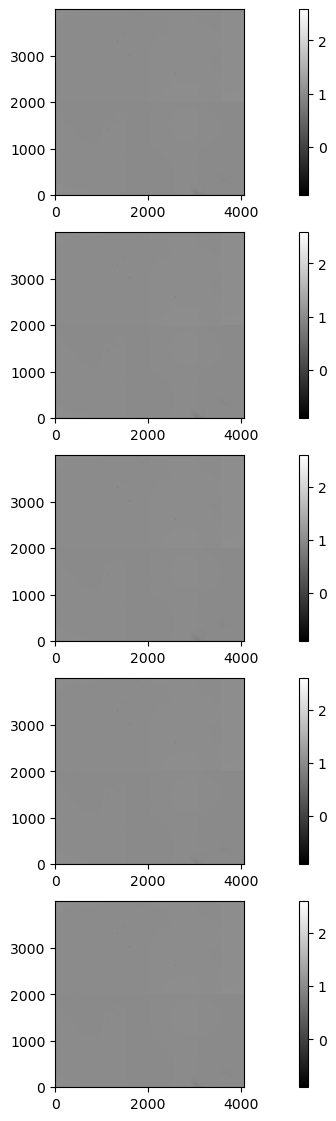

In [19]:
if plot_flats:
    fig = plt.figure(figsize=(14,14))
    for i,fid_ in enumerate(flats_selected):
        if i<max_plots:
            flat_img_ = butler.get(
                "flat",
                instrument="LATISS", exposure=fid_, detector=0,
                collections=calibCollections)
            data_ = flat_img_.getImage().array
            ax = fig.add_subplot(max_plots,1,i+1)
            im = ax.imshow(data_,cmap="gray",origin='lower')#,norm=LogNorm())
            plt.colorbar(im,ax=ax)